In [98]:
from __future__ import print_function
import numpy as np
import PIL.Image as Image
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time

In [99]:
file_path = '/users/jamesthomas/MachineLearning_Python/Lab2/images/resize/thumb/'
file_path_2 = '/users/jamesthomas/MachineLearning_Python/Lab2/images/full_size/'


df = pd.read_csv(file_path_2+'sample_labels.csv')
new_df = df[['Image Index','Finding Labels']]
new_df.groupby(['Finding Labels'])

In [100]:
df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139,0.139
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168,0.168
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168,0.168
3,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143,0.143
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,055Y,F,AP,2500,2048,0.168,0.168


In [101]:
# check if the frame contains 'No Finding' True if the patient was sick, False if not
y_sick = ~df['Finding Labels'].str.contains('No Finding')

# now check for pneumonia, True if patient has pneumonia, False else
y_pneumonia = df['Finding Labels'].str.contains('Pneumonia')


# now make target for all diseases

disease_list = ['Hernia', 'Pneumonia', 'Fibrosis', 'Edema', 'Emphysema', 'Cardiomegaly', 'Pleural_Thickening',
                'Consolidation', 'Pneumothorax', 'Mass', 'Nodule', 'Atelectasis', 'Effusion', 'Infiltration', 'No Finding']

def disease_to_list(string, full_results = disease_list):
    '''Function to generate a list of the different diseases each patient has
    Inputs
    string: the string containing the diseases, ie df['Finding Labels']
    full_results: the list of all possible diseases used for the indices in the resulting list
    Returns
    list: a list with False if the patient didn't have the disease and True if the patient did. Indices based on full_results
    '''
    diseases = string.split('|')
    result = [False]*len(full_results)
    
    for d in diseases:
        result[full_results.index(d)] = True
    return result

y_all_l = df['Finding Labels'].apply(disease_to_list) # series version of .apply(). This returns a pd.series of lists
y_all = pd.DataFrame(y_all_l.tolist(), columns = disease_list) # convert to a pd.dataframe

# now check that the totals match kaggle https://www.kaggle.com/nih-chest-xrays/sample
y_all.sum(axis=0)

Hernia                  13
Pneumonia               62
Fibrosis                84
Edema                  118
Emphysema              127
Cardiomegaly           141
Pleural_Thickening     176
Consolidation          226
Pneumothorax           271
Mass                   284
Nodule                 313
Atelectasis            508
Effusion               644
Infiltration           967
No Finding            3044
dtype: int64

In [102]:
from sklearn.model_selection import train_test_split

dat_train, dat_test, y_train, y_test = train_test_split(df, y_sick, test_size=0.2, random_state=42, stratify=y_sick)

In [47]:
size = 256

X_test = np.empty([len(dat_test), size, size, 1], dtype=np.float32) # preallocate
X_train = np.empty([len(dat_train), size, size, 1], dtype=np.float32) # num_images, img_width, img_height, num_channels

X_test[:,:,:,0]=1
X_train[:,:,:,0]=1

index = 0
t_start = time.time()
for name in dat_test['Image Index']:
    clear_output(wait=True)
    print('working on test {}, {}, {:.2f}'.format(index, name, time.time()-t_start))
    img = Image.open(file_path+name)
    #display(img)
    X_test[index,:,:,0] = np.array(img)/255.0-0.5
    index+=1

index = 0
t_start = time.time()
for name in dat_train['Image Index']:
    clear_output(wait=True)
    print('working on train {}, {}, {:.2f}'.format(index, name, time.time()-t_start))
    img = Image.open(file_path+name)
    #display(img)
    X_train[index,:,:,0] = np.array(img)/255.5-0.5
    index+=1

working on train 4483, 00022208_005.png, 16.22


In [7]:
# the datagen 
# from class: https://github.com/eclarson/MachineLearningNotebooks/blob/master/12.%20More%20Advanced%20CNN%20Techniques.ipynb
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=5, # used, Int. Degree range for random rotations.
    width_shift_range=0.1, # used, Float (fraction of total width). Range for random horizontal shifts.
    height_shift_range=0.1, # used,  Float (fraction of total height). Range for random vertical shifts.
    shear_range=0., # Float. Shear Intensity (Shear angle in counter-clockwise direction as radians)
    zoom_range=0.,
    channel_shift_range=0.,
    fill_mode='nearest',
    cval=0.,
    horizontal_flip=True,
    vertical_flip=False,
    rescale=None)

/hpc/applications/anaconda/3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [29]:
# Convolutional Neural Network
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input, Dense, Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D

visible = Input(shape=(size,size,1))

conv1 = Conv2D(32, kernel_size=3, activation='relu')(visible)
#conv1 = Conv2D(32, kernel_size=1, activation='relu')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(16, kernel_size=3, activation='relu')(pool1)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(16, kernel_size=3, activation='relu')(pool2)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

conv4 = Conv2D(16, kernel_size=3, activation='relu')(pool3)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

conv5 = Conv2D(1, kernel_size=3, activation='relu',name='final_conv')(pool4)
pool5 = MaxPooling2D(pool_size=(2, 2))(conv5)


flat = Flatten()(pool5)
hidden1 = Dense(20, activation='relu')(flat)
hidden2 = Dense(10, activation='relu')(hidden1)
output = Dense(1, activation='sigmoid')(hidden2)

model = Model(inputs=visible, outputs=output)
# summarize layers
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 256, 256, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 254, 254, 32)      320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 125, 125, 16)      4624      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 62, 62, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 60, 60, 16)        2320      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 30, 30, 16)        0         
__________

In [9]:
from keras.utils import to_categorical
import tensorflow as tf
#print(y_train.shape)
#print(y_test.shape)
#y_train = to_categorical(y_train)
#y_test = to_categorical(y_test)
print(y_train.shape)
print(y_test.shape)

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])


model.fit_generator(datagen.flow(X_train, y_train, batch_size=32), 
                        steps_per_epoch=int(len(X_train)/32), # how many generators to go through per epoch
                        epochs=5, verbose=1,
                        validation_data=(X_test,y_test)
                        )

(4484,)
(1122,)
Epoch 1/5
140/140 [==============================] - 85s 610ms/step - loss: 0.6782 - acc: 0.5795 - val_loss: 0.6586 - val_acc: 0.6337
Epoch 2/5
140/140 [==============================] - 104s 742ms/step - loss: 0.6705 - acc: 0.5987 - val_loss: 0.6434 - val_acc: 0.6453
Epoch 3/5
140/140 [==============================] - 91s 652ms/step - loss: 0.6672 - acc: 0.6071 - val_loss: 0.6444 - val_acc: 0.6426
Epoch 4/5
140/140 [==============================] - 86s 611ms/step - loss: 0.6658 - acc: 0.6056 - val_loss: 0.6441 - val_acc: 0.6471
Epoch 5/5
140/140 [==============================] - 97s 690ms/step - loss: 0.6655 - acc: 0.6065 - val_loss: 0.6512 - val_acc: 0.6417


In [10]:
heat_map_model = Model(inputs=model.input, outputs=model.get_layer('final_conv').output)

heat_map_data = heat_map_model.predict(X_train)

In [11]:
from scipy.ndimage import zoom

factor = 21.33
upsacle = np.array([zoom(x,(factor,factor,1),order=2) for x in heat_map_data])

/users/xjing/.local/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


In [12]:
#heat_map_data = np.array([imresize(np.reshape(x,(12,12)), size=(256,256), `='nearest') for x in heat_map_data])
#print(heat_map_data.shape)

In [13]:
import pylab
def heat_plot(i):
    data = upsacle[i][:,:,0]

    plt.subplot(111)
    ax1=plt.subplot(1, 1, 1)

    im = np.reshape(X_train[i],(256,256))
    ax1.imshow(im,cmap=pylab.gray())

    heat=ax1.imshow(data, cmap='hot', interpolation='nearest',alpha=0.2)
    plt.colorbar(heat)

    plt.show()

/hpc/applications/anaconda/3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


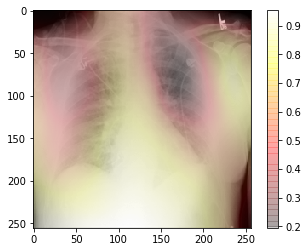

In [14]:
heat_plot(36)

In [38]:
from scipy import fftpack
im_fft = fftpack.fft2(img)

size = 256

X_test_fft = np.empty([len(dat_test), size, size, 2], dtype=np.float32) # preallocate
X_train_fft = np.empty([len(dat_train), size, size, 2], dtype=np.float32) # num_images, img_width, img_height, num_channels


index = 0
t_start = time.time()
for name in dat_test['Image Index']:
    clear_output(wait=True)
    print('working on test {}, {}, {:.2f}'.format(index, name, time.time()-t_start))
    img = Image.open(file_path+name)
    #display(img)
    X_test_fft[index,:,:,0] = np.real(fftpack.fft2(img))
    X_test_fft[index,:,:,1] = np.imag(fftpack.fft2(img))
    index+=1

index = 0
t_start = time.time()
for name in dat_train['Image Index']:
    clear_output(wait=True)
    print('working on train {}, {}, {:.2f}'.format(index, name, time.time()-t_start))
    img = Image.open(file_path+name)
    #display(img)
    X_train_fft[index,:,:,0] = np.real(fftpack.fft2(img))
    X_train_fft[index,:,:,1] = np.imag(fftpack.fft2(img))
    index+=1

working on train 4483, 00022208_005.png, 33.99


In [39]:
visible = Input(shape=(size,size,2))

conv1 = Conv2D(32, kernel_size=3, activation='relu')(visible)
#conv1 = Conv2D(32, kernel_size=1, activation='relu')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(16, kernel_size=3, activation='relu')(pool1)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(16, kernel_size=3, activation='relu')(pool2)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

conv4 = Conv2D(16, kernel_size=3, activation='relu')(pool3)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

conv5 = Conv2D(1, kernel_size=3, activation='relu',name='final_conv')(pool4)
pool5 = MaxPooling2D(pool_size=(2, 2))(conv5)


flat = Flatten()(pool5)
hidden1 = Dense(20, activation='relu')(flat)
hidden2 = Dense(10, activation='relu')(hidden1)
output = Dense(1, activation='sigmoid')(hidden2)

model = Model(inputs=visible, outputs=output)
# summarize layers
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 256, 256, 2)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 254, 254, 32)      608       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 125, 125, 16)      4624      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 62, 62, 16)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 60, 60, 16)        2320      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 30, 30, 16)        0         
__________

In [40]:
from keras.utils import to_categorical
import tensorflow as tf
#print(y_train.shape)
#print(y_test.shape)
#y_train = to_categorical(y_train)
#y_test = to_categorical(y_test)
print(y_train.shape)
print(y_test.shape)

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])


model.fit(X_train_fft, y_train,
        epochs=5,batch_size=64,verbose=1,
        validation_data=(X_test_fft,y_test)
        )

(4484,)
(1122,)
Train on 4484 samples, validate on 1122 samples
Epoch 1/5
4484/4484 [==============================] - 144s 32ms/step - loss: 8.6428 - acc: 0.4554 - val_loss: 8.6532 - val_acc: 0.4572
Epoch 2/5
4484/4484 [==============================] - 129s 29ms/step - loss: 8.6574 - acc: 0.4570 - val_loss: 8.6532 - val_acc: 0.4572
Epoch 3/5
4484/4484 [==============================] - 150s 33ms/step - loss: 8.6574 - acc: 0.4570 - val_loss: 8.6532 - val_acc: 0.4572
Epoch 4/5
4484/4484 [==============================] - 144s 32ms/step - loss: 8.6574 - acc: 0.4570 - val_loss: 8.6532 - val_acc: 0.4572
Epoch 5/5
4484/4484 [==============================] - 143s 32ms/step - loss: 8.6574 - acc: 0.4570 - val_loss: 8.6532 - val_acc: 0.4572


In [43]:
visible = Input(shape=(size,size,2))

flat = Flatten()(visible)
hidden1 = Dense(20, activation='relu')(flat)
hidden2 = Dense(10, activation='relu')(hidden1)
hidden3 = Dense(10, activation='relu')(hidden2)
output = Dense(1, activation='sigmoid')(hidden3)

model_mlp = Model(inputs=visible, outputs=output)
# summarize layers
print(model_mlp.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 256, 256, 2)       0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 131072)            0         
_________________________________________________________________
dense_20 (Dense)             (None, 20)                2621460   
_________________________________________________________________
dense_21 (Dense)             (None, 10)                210       
_________________________________________________________________
dense_22 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 11        
Total params: 2,621,791
Trainable params: 2,621,791
Non-trainable params: 0
_________________________________________________________________


In [44]:
model_mlp.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])


model_mlp.fit(X_train_fft, y_train,
        epochs=5,batch_size=64,verbose=1,
        validation_data=(X_test_fft,y_test)
        )

Train on 4484 samples, validate on 1122 samples
Epoch 1/5
4484/4484 [==============================] - 14s 3ms/step - loss: 8.6574 - acc: 0.4570 - val_loss: 8.6532 - val_acc: 0.4572
Epoch 2/5
4484/4484 [==============================] - 7s 2ms/step - loss: 8.6574 - acc: 0.4570 - val_loss: 8.6532 - val_acc: 0.4572
Epoch 3/5
4484/4484 [==============================] - 11s 2ms/step - loss: 8.6574 - acc: 0.4570 - val_loss: 8.6532 - val_acc: 0.4572
Epoch 4/5
4484/4484 [==============================] - 6s 1ms/step - loss: 8.6574 - acc: 0.4570 - val_loss: 8.6532 - val_acc: 0.4572
Epoch 5/5
4484/4484 [==============================] - 5s 1ms/step - loss: 8.6574 - acc: 0.4570 - val_loss: 8.6532 - val_acc: 0.4572


In [45]:
visible = Input(shape=(size,size,1))

flat = Flatten()(visible)
hidden1 = Dense(20, activation='relu')(flat)
hidden2 = Dense(10, activation='relu')(hidden1)
hidden3 = Dense(10, activation='relu')(hidden2)
output = Dense(1, activation='sigmoid')(hidden3)

model_mlp = Model(inputs=visible, outputs=output)
# summarize layers
print(model_mlp.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 256, 256, 1)       0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 65536)             0         
_________________________________________________________________
dense_24 (Dense)             (None, 20)                1310740   
_________________________________________________________________
dense_25 (Dense)             (None, 10)                210       
_________________________________________________________________
dense_26 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 11        
Total params: 1,311,071
Trainable params: 1,311,071
Non-trainable params: 0
_________________________________________________________________


In [48]:
model_mlp.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])


model_mlp.fit_generator(datagen.flow(X_train, y_train, batch_size=32), 
                        steps_per_epoch=int(len(X_train)/32), # how many generators to go through per epoch
                        epochs=5, verbose=1,
                        validation_data=(X_test,y_test)
                        )

Epoch 1/5
140/140 [==============================] - 26s 182ms/step - loss: 0.8252 - acc: 0.5185 - val_loss: 0.6915 - val_acc: 0.5579
Epoch 2/5
140/140 [==============================] - 19s 135ms/step - loss: 0.7091 - acc: 0.5413 - val_loss: 0.6986 - val_acc: 0.5463
Epoch 3/5
140/140 [==============================] - 18s 130ms/step - loss: 0.7179 - acc: 0.5420 - val_loss: 0.8215 - val_acc: 0.5419
Epoch 4/5
140/140 [==============================] - 18s 129ms/step - loss: 0.6997 - acc: 0.5389 - val_loss: 0.6936 - val_acc: 0.5446
Epoch 5/5
140/140 [==============================] - 18s 131ms/step - loss: 0.6963 - acc: 0.5460 - val_loss: 0.6898 - val_acc: 0.5428


In [15]:
import gc
import keras.backend as K

model = None
gc.collect()
K.clear_session()

In [4]:
pd.__version__

'0.24.1'

In [38]:
from sklearn.metrics import confusion_matrix

cost_matrix = np.array([[0,2],[9,-1]])
print('cost matrix used is ')
print(cost_matrix)

def custom_cost_metric(y_true, y_pred, cost_mat=cost_matrix):
    conf_mat = confusion_matrix(y_true, y_pred)
    cost = np.sum(cost_mat*conf_mat)/len(y_true)
    return cost

cost matrix used is 
[[ 0  2]
 [ 9 -1]]


In [39]:
import pickle
cost_dict_ens = pickle.load( open( "Ensembles.pickle", "rb" ) )
cost_dict_le = pickle.load( open( 'LeNet5.pickle', 'rb'))
cost_dict_mlp = pickle.load( open('MLP.pickle', 'rb'))
cost_dict_xce = pickle.load( open('XCeption.pickle', 'rb'))
cost_dict_res = pickle.load( open('ResNet.pickle','rb'))

y_true = pickle.load( open('y_true.pickle','rb'))
y_true = y_true.values

In [40]:
cost_list = []
for cost_dict in [cost_dict_ens,cost_dict_le,cost_dict_mlp,cost_dict_xce,cost_dict_res]:
    for key in cost_dict:
        cost_dict[key] = custom_cost_metric(y_true, (cost_dict[key]>0.5).astype(int), cost_mat=cost_matrix)
    cost_list += [list(cost_dict.values())]

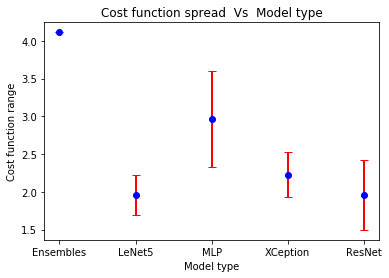

In [61]:
import matplotlib.pyplot as plt
import numpy as np
x=['Ensembles','LeNet5','MLP','XCeption','ResNet']
dy=np.array([(max(li)-min(li))/2 for li in cost_list])
y=np.array([sum(li)/len(li) for li in cost_list])

plt.errorbar(x,y,yerr=dy,fmt='o',ecolor='r',color='b',elinewidth=2,capsize=4)
plt.ylabel('Cost function range')
plt.xlabel('Model type')
plt.title('Cost function spread  Vs  Model type')
plt.show()

In [62]:
epoch_his = pickle.load(open('epoch_results.pickle','rb'))

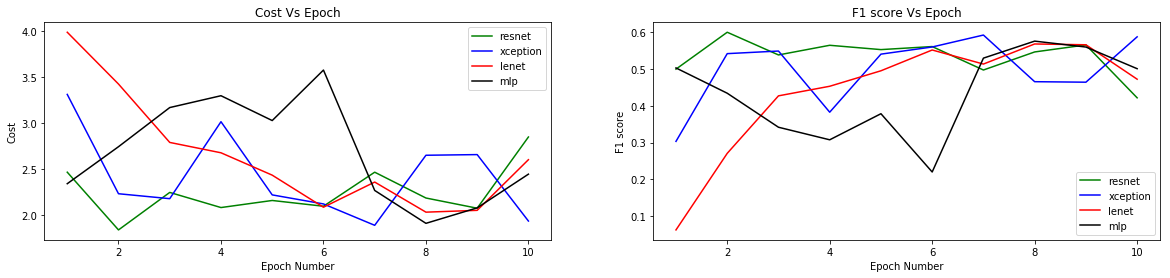

In [79]:
colors = ['green','blue','red','black','yellow']
plt.figure(figsize=(20,4))


plt.subplot(1,2,1)
plt.title('Cost Vs Epoch')
cnt = 0
for key in epoch_his:
    plt.plot([1,2,3,4,5,6,7,8,9,10],[li[1] for li in epoch_his[key]], color=colors[cnt], label=key)
    cnt += 1
plt.legend()
plt.xlabel('Epoch Number')
plt.ylabel('Cost')


plt.subplot(1,2,2)
cnt = 0
plt.title('F1 score Vs Epoch')
for key in epoch_his:
    plt.plot([1,2,3,4,5,6,7,8,9,10],[li[0] for li in epoch_his[key]], color=colors[cnt], label=key)
    cnt += 1
plt.legend()
plt.xlabel('Epoch Number')
plt.ylabel('F1 score')
plt.show()

In [80]:
comp = pickle.load(open('compare_models.pickle','rb'))

In [84]:
for key in comp:
    comp[key] = [custom_cost_metric(y_true, (li>0.5).astype(int), cost_mat=cost_matrix) for li in comp[key]]
    print(key,comp[key])

resnet [1.8850267379679144, 1.6319073083778965, 1.7691622103386808, 1.9955436720142603, 1.7727272727272727]
mlp [2.642602495543672, 2.820855614973262, 1.5409982174688057, 2.7442067736185383, 3.8101604278074865]


In [91]:
import numpy as np, scipy.stats as st
st_range_res = st.t.interval(0.95, len(comp['resnet'])-1, loc=np.mean(comp['resnet']), scale=st.sem(comp['resnet']))

print('MLP performance is within range (95% confidence):',st_range_res)

cost_mlp_ave = sum(comp['mlp'])/5
print('Average mlp cost (customized metric) is', cost_mlp_ave)
print('MLP is indisguishable compared to resnet: ' ,cost_mlp_ave>=st_range_res[0] and cost_mlp_ave<= st_range_res[1])
if cost_mlp_ave<=st_range_res[0]:
    print('MLP is better comparing to resnet.')
else:
    print('ResNet is better comparing to MLP.')

MLP performance is within range (95% confidence): (1.641049344400297, 1.9806975361701133)
Average mlp cost (customized metric) is 2.711764705882353
MLP is indisguishable compared to resnet:  False
ResNet is better comparing to MLP.


The following part is for transfer learning.

Notice that X_train, X_test are for original image, x_train, x_test are for transfer learning.

In [103]:
import keras

In [107]:
#reload the images, using three channels
size = 256
X_test = np.empty([len(dat_test), size, size, 3], dtype=np.float32) # preallocate
X_train = np.empty([len(dat_train), size, size, 3], dtype=np.float32) # num_images, img_width, img_height, num_channels

X_test[:,:,:,0]=1
X_train[:,:,:,0]=1

index = 0
t_start = time.time()
for name in dat_test['Image Index']:
    clear_output(wait=True)
    print('working on test {}, {}, {:.2f}'.format(index, name, time.time()-t_start))
    img = keras.preprocessing.image.load_img(file_path+name, grayscale = False)
    #display(img)
    X_test[index,:,:,:] = np.array(img)/255.0-0.5
    index+=1

index = 0
t_start = time.time()
for name in dat_train['Image Index']:
    clear_output(wait=True)
    print('working on train {}, {}, {:.2f}'.format(index, name, time.time()-t_start))
    img = keras.preprocessing.image.load_img(file_path+name, grayscale = False)
    #display(img)
    X_train[index,:,:,:] = np.array(img)/255.5-0.5
    index+=1

working on train 4483, 00022208_005.png, 60.31


In [105]:
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np

res_model = ResNet50(weights='imagenet')

In [108]:
from keras.utils import to_categorical

NUM_CLASSES = 1

(x_train, y_train), (x_test, y_test) = (X_train, y_train), (X_test,y_test)

y_train_ohe = y_train
y_test_ohe = y_test

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(4484, 256, 256, 3)
(4484,)
(1122, 256, 256, 3)
(1122,)


In [109]:
# connect new layers to the output
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input, decode_predictions

# load only convolutional layers of resnet:
if 'res_no_top' not in locals():
    res_no_top = ResNet50(weights='imagenet', include_top=False)

x = x_train[0]
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

%time 
preds = res_no_top.predict(x)
preds.shape

CPU times: user 12 µs, sys: 0 ns, total: 12 µs
Wall time: 28.4 µs


(1, 1, 1, 2048)

In [110]:
x_train_up = preprocess_input(x_train)
x_test_up = preprocess_input(x_test)

In [111]:
%%time
#get the result after passing the image to the resnet to the last conv layer

x_train_resnet = res_no_top.predict(x_train_up)
x_test_resnet = res_no_top.predict(x_test_up)

CPU times: user 1h 20min 47s, sys: 21min 31s, total: 1h 42min 19s
Wall time: 15min 30s


In [112]:
from keras.layers import SeparableConv2D
from keras.layers.normalization import BatchNormalization
from keras.layers import Add, Flatten, Dense
from keras.layers import average, concatenate
from keras.models import Input, Model


# let's add a fully-connected layer
input_x = Input(shape=x_train_resnet[0].shape)
x = Flatten()(input_x)
x = Dense(200, activation='relu',kernel_initializer='he_uniform')(x)
x = Dense(200, activation='relu',kernel_initializer='he_uniform')(x)
# and a fully connected layer 
predictions = Dense(NUM_CLASSES, activation='sigmoid', kernel_initializer='glorot_uniform')(x)

model = Model(inputs=input_x, outputs=predictions)

model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 1, 1, 2048)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 200)               409800    
_________________________________________________________________
dense_2 (Dense)              (None, 200)               40200     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 201       
Total params: 450,201
Trainable params: 450,201
Non-trainable params: 0
_________________________________________________________________


In [ ]:
y_train_ohe_resnet = y_train_ohe[:x_train_resnet.shape[0]]

model.compile(optimizer='rmsprop', loss='mean_squared_error',metrics=['accuracy'])

model.fit(x_train_resnet,y_train_ohe_resnet,epochs=5,
          batch_size=64,verbose=1,
         validation_data=(x_test_resnet, y_test_ohe[:x_test_resnet.shape[0]]))


In the code above, we used the weight that is from ResNet 50. However the ResNet was not trained to identify the medical conditions. Here, we will use the ResNet architecture and make all layers trainable.

In [ ]:
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input, decode_predictions


x_train_up = preprocess_input(x_train)
x_test_up = preprocess_input(x_test)

In [ ]:
model = ResNet50(weights='imagenet', include_top=False,input_shape=(256, 256, 3))
# Freeze the layers which you don't want to train. Here I am freezing the all layers.
for layer in model.layers[:]:
    layer.trainable = True

# Adding custom Layer
# We only add
x = model.output
x = Flatten()(x)
x = Dense(200, activation='relu',kernel_initializer='he_uniform')(x)
x = Dense(200, activation='relu',kernel_initializer='he_uniform')(x)
# and a fully connected layer 
predictions = Dense(1, activation='sigmoid', kernel_initializer='glorot_uniform')(x)


# creating the final model 
model_final = Model(input = model.input, output = predictions)

# compile the model 
model_final.compile(optimizer='rmsprop', loss='mean_squared_error',metrics=['accuracy'])

model_final.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 128, 128, 64) 9472        input_4[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 128, 128, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_99 (Activation)      (None, 128, 128, 64) 0           bn_conv1[0][0]                   
__________________________________________________________________________________________________
max_poolin

/hpc/applications/anaconda/3/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


In [ ]:
y_train_ohe_resnet = y_train_ohe[:x_train_up.shape[0]]


model_final.fit(x_train_up,y_train_ohe_resnet,epochs=5,
          batch_size=64,verbose=1,
         validation_data=(x_test_up, y_test_ohe[:x_test_up.shape[0]]))

Train on 4484 samples, validate on 1122 samples
Epoch 1/5
4484/4484 [==============================] - 5711s 1s/step - loss: 0.3123 - acc: 0.5346 - val_loss: 0.2864 - val_acc: 0.4572
Epoch 2/5
4484/4484 [==============================] - 5716s 1s/step - loss: 0.2566 - acc: 0.5511 - val_loss: 0.4343 - val_acc: 0.5428
Epoch 3/5
3456/4484 [======================>.......] - ETA: 21:00 - loss: 0.2489 - acc: 0.5359